# 安装依赖库

In [ ]:
# 必装的第三方库，根据需要安装
%pip install torch
%pip install torchdeq
%pip install matplotlib
%pip install ninja

# 导入必要的库

In [193]:
import torch, json, types, os, math
import torch.nn as nn
from torch.amp import autocast
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torchdeq import get_deq

import numpy as np

import matplotlib.pyplot as plt

from IPython.display import clear_output, display
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 定义脚本模块

In [194]:
MyModule = torch.jit.ScriptModule
MyFunction = torch.jit.script_method
MyStatic = torch.jit.script

# 适配

In [195]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cuda.matmul.allow_tf32 = True
    from wkv7 import RUN_CUDA_RWKV7g as wkv
else:
    device = torch.device("cpu")
    
    def wkv(r, w, k, v, a, b):
        HEAD_SIZE = 64
        B, T, C = r.size()
        H = C // HEAD_SIZE
        N = HEAD_SIZE
        r = r.view(B, T, H, N).float()
        k = k.view(B, T, H, N).float()
        v = v.view(B, T, H, N).float()
        a = a.view(B, T, H, N).float()
        b = b.view(B, T, H, N).float()
        w = torch.exp(-torch.exp(w.view(B, T, H, N).float()))
        out = torch.zeros((B, T, H, N), device=r.device, dtype=torch.float)
        state = torch.zeros((B, H, N, N), device=r.device, dtype=torch.float)

        for t in range(T):
            kk = k[:, t, :].view(B, H, 1, N)
            rr = r[:, t, :].view(B, H, N, 1)
            vv = v[:, t, :].view(B, H, N, 1)
            aa = a[:, t, :].view(B, H, N, 1)
            bb = b[:, t, :].view(B, H, 1, N)
            state = state * w[: , t, :, None, :] + state @ aa @ bb + vv @ kk
            out[:, t, :] = (state @ rr).view(B, H, N)

        return out.view(B, T, C)
    
DTYPE = torch.float32

# 配置

In [196]:
args=types.SimpleNamespace()

args.n_embd = 768
args.head_size = 64
args.vocab_size = 65536

args.D_DECAY_LORA = 64
args.D_AAA_LORA = 64
args.D_MV_LORA = 32
args.D_GATE_LORA = 128

max_iter=12
f_tol=1e-6

# 定义模型

In [197]:
class Tmix(MyModule):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.n_embd = args.n_embd
        self.head_size = args.head_size
        self.n_head = args.n_embd // self.head_size

        assert args.n_embd % self.head_size == 0

        H = self.n_head
        N = self.head_size
        C = args.n_embd

        D_DECAY_LORA = args.D_DECAY_LORA
        D_AAA_LORA = args.D_AAA_LORA
        D_MV_LORA = args.D_MV_LORA
        D_GATE_LORA = args.D_GATE_LORA

        self.x_r = nn.Parameter(torch.randn(1, 1, C))
        self.x_w = nn.Parameter(torch.randn(1, 1, C))
        self.x_k = nn.Parameter(torch.randn(1, 1, C))
        self.x_v = nn.Parameter(torch.randn(1, 1, C))
        self.x_a = nn.Parameter(torch.randn(1, 1, C))
        self.x_g = nn.Parameter(torch.randn(1, 1, C))

        self.w0 = nn.Parameter(torch.randn(1, 1, C))
        self.w1 = nn.Parameter(torch.randn(C, D_DECAY_LORA))
        self.w2 = nn.Parameter(torch.randn(D_DECAY_LORA, C))

        self.a0 = nn.Parameter(torch.randn(1, 1, C))
        self.a1 = nn.Parameter(torch.randn(C, D_AAA_LORA))
        self.a2 = nn.Parameter(torch.randn(D_AAA_LORA, C))

        self.v0 = nn.Parameter(torch.randn(1, 1, C))
        self.v1 = nn.Parameter(torch.randn(C, D_MV_LORA))
        self.v2 = nn.Parameter(torch.randn(D_MV_LORA, C))

        self.g1 = nn.Parameter(torch.randn(C, D_GATE_LORA))
        self.g2 = nn.Parameter(torch.randn(D_GATE_LORA, C))

        self.k_k = nn.Parameter(torch.randn(1, 1, C))
        self.k_a = nn.Parameter(torch.randn(1, 1, C))
        self.r_k = nn.Parameter(torch.randn(H, N))

        self.receptance = nn.Linear(C, C, bias=False)
        self.key = nn.Linear(C, C, bias=False)
        self.value = nn.Linear(C, C, bias=False)
        self.output = nn.Linear(C, C, bias=False)
        self.ln_x = nn.GroupNorm(H, C, eps=64e-5)  # !!! notice eps value !!!

        self.time_shift = nn.ZeroPad2d((0, 0, 1, -1))
        self.init_weights()

    def init_weights(self):
        import math
        D_DECAY_LORA = self.args.D_DECAY_LORA
        D_AAA_LORA = self.args.D_AAA_LORA
        D_MV_LORA = self.args.D_MV_LORA
        D_GATE_LORA = self.args.D_GATE_LORA

        C = self.n_embd 
        H = self.n_head
        
        linear_layers = {
            "receptance": self.receptance,
            "key": self.key,
            "value": self.value,
            "output": self.output
        }
        for name, layer in linear_layers.items():
            if name in ["receptance", "key", "value"]:
                nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('linear'))
            elif name == "output":
                # nn.init.zeros_(layer.weight)#设为0
                nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('linear'))
        
        input_params = [self.x_r, self.x_w, self.x_k, self.x_v, self.x_a, self.x_g]
        for param in input_params:
            nn.init.normal_(param, mean=0.0, std=0.01)
        
        kernel_params = [self.k_k, self.k_a]
        for param in kernel_params:
            nn.init.normal_(param, mean=0.0, std=0.02)
        
        nn.init.normal_(self.r_k, mean=0.0, std=0.1) 
        for h in range(H):
            self.r_k.data[h] += 0.1 * h
        
        lora_biases = [self.w0, self.a0, self.v0]
        for param in lora_biases:
            nn.init.normal_(param, mean=0.0, std=0.02)
        
        def init_lora_param(param, in_dim, out_dim, nonlinearity='linear'):
            gain = nn.init.calculate_gain(nonlinearity)
            std = gain * math.sqrt(2.0 / (in_dim + out_dim))
            nn.init.normal_(param, mean=0.0, std=std)

        lora_inputs = [
            (self.w1, C, D_DECAY_LORA, 'tanh'),
            (self.a1, C, D_AAA_LORA, 'sigmoid'),
            (self.v1, C, D_MV_LORA, 'linear'), 
            (self.g1, C, D_GATE_LORA, 'sigmoid')
        ]
        lora_outputs = [
            (self.w2, D_DECAY_LORA, C, 'linear'),
            (self.a2, D_AAA_LORA, C, 'linear'),
            (self.v2, D_MV_LORA, C, 'linear'),
            (self.g2, D_GATE_LORA, C, 'linear')
        ]
        for param, in_dim, out_dim, nonlinearity in lora_inputs + lora_outputs:
            init_lora_param(param, in_dim, out_dim, nonlinearity)

    @MyFunction
    def forward(self, x, v_first):
        B, T, C = x.size()
        H = self.n_head

        xx = self.time_shift(x) - x

        xr = x + xx * self.x_r
        xw = x + xx * self.x_w
        xk = x + xx * self.x_k
        xv = x + xx * self.x_v
        xa = x + xx * self.x_a
        xg = x + xx * self.x_g

        r = self.receptance(xr)
        w = (
            -F.softplus(-(self.w0 + torch.tanh(xw @ self.w1) @ self.w2)) - 0.5
        )  # soft-clamp to (-inf, -0.5)
        k = self.key(xk)
        v = self.value(xv)

        if torch.all(v_first == 0):
            v_first = v  # store the v of the first layer
        else:
            v = v + (v_first - v) * torch.sigmoid(
                self.v0 + (xv @ self.v1) @ self.v2
            )  # add value residual

        a = torch.sigmoid(
            self.a0 + (xa @ self.a1) @ self.a2
        )  # a is "in-context learning rate"
        g = torch.sigmoid(xg @ self.g1) @ self.g2

        kk = k * self.k_k
        kk = F.normalize(kk.view(B, T, H, -1), dim=-1, p=2.0).view(B, T, C)
        k = k * (1 + (a - 1) * self.k_a)

        x = wkv(r, w, k, v, -kk, kk * a)
        x = self.ln_x(x.view(B * T, C)).view(B, T, C)
        x = x + (
            (r.view(B, T, H, -1) * k.view(B, T, H, -1) * self.r_k).sum(
                dim=-1, keepdim=True
            )
            * v.view(B, T, H, -1)
        ).view(B, T, C)
        x = self.output(x * g)
        return x, v_first

In [198]:
class Cmix(MyModule):
    def __init__(self, args):
        super().__init__()
        self.n_embd = args.n_embd
        self.time_shift = nn.ZeroPad2d((0, 0, 1, -1))
        self.x_k = nn.Parameter(torch.randn(1, 1, args.n_embd))
        self.key = nn.Linear(args.n_embd, args.n_embd * 4, bias=False)
        self.value = nn.Linear(args.n_embd * 4, args.n_embd, bias=False)
        self.init_weights()

    def init_weights(self):
        nn.init.normal_(self.x_k, mean=0.0, std=1.0 / (self.n_embd**0.5))
        nn.init.kaiming_uniform_(
            self.key.weight,
            mode="fan_in",
            nonlinearity="relu",
            a=0.5, 
        )
        nn.init.kaiming_uniform_(
            self.value.weight, mode="fan_in", nonlinearity="linear"
        )

    @MyFunction
    def forward(self, x):
        xx = self.time_shift(x) - x
        k = x + xx * self.x_k
        k = torch.relu(self.key(k)) ** 2
        return self.value(k)

In [ ]:
class Block(MyModule):
    def __init__(self, args):
        super().__init__()
        self.lr=nn.Parameter(torch.tensor(6e-4)) # 为了到接着训练而临时设置的，可移除

        self.ln1 = nn.LayerNorm(args.n_embd)
        self.ln2 = nn.LayerNorm(args.n_embd)
        self.att = Tmix(args)
        self.ffn = Cmix(args)
        self.v_first=torch.zeros(1,1,1)

    @MyFunction
    def forward(self, x):
        xx, self.v_first = self.att(self.ln1(x), self.v_first)
        x = x + xx
        x = self.ffn(self.ln2(x))
        return x


# 创建模型

In [200]:
block = Block(args).to(dtype=DTYPE, device=device)
if os.path.exists('block.pth'):
    block.load_state_dict(torch.load('block.pth', map_location=device))
    print("加载之前保存的参数，继续训练")

# 定义均衡函数
def f(z):return block(z)

# 准备数据

In [ ]:
class MyDataset(Dataset):
    def __init__(self, file_path):
        self.tokens = []
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                data = json.loads(line)
                self.tokens.append(data["tokens"])

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, index):
        tokens=self.tokens[index]
        input = tokens[:-1]
        target=tokens[1:]
        return input,target
    
def my_collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs=list(inputs)
    targets=list(targets)
    inputs = torch.tensor(inputs,device=device)
    targets = torch.tensor(targets,device=device)
    return inputs, targets

dataset = MyDataset("test.jsonl")
data_loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, collate_fn=my_collate_fn)

# 外置准备

In [202]:
#从现有模型参数中提取参数
state_dict = torch.load('g1a.pth',map_location=device)

emb=nn.Embedding(args.vocab_size,args.n_embd).to(device)
embedding_params = state_dict['emb.weight']
emb.weight.data.copy_(embedding_params)
for param in emb.parameters():
    param.requires_grad = False

head=nn.Linear(args.n_embd,args.vocab_size).to(device)
head.weight.data.copy_(state_dict['head.weight'])
for param in head.parameters():
    param.requires_grad = False

# 准备训练

In [203]:
# 获取支持隐式微分的 DEQ 层
deq = get_deq(
    ift=True,  # True为开启训练
    f_solver="broyden",
    f_max_iter=max_iter,
    f_tol=f_tol,
    b_solver="broyden",
    b_max_iter=max_iter,
    b_tol=f_tol,
)
deq = deq.to(device)

In [204]:
def plot_loss(loss_history,max_display=99999):
    epochs = len(loss_history)
    fig, ax = plt.subplots(figsize=(10, 6))
    x = range(max(1, epochs - max_display + 1), epochs + 1)
    y=loss_history[-max_display:]
    ax.plot(x, y,"o-", color="#7e46f0", linewidth=5)
    ax.set_title('Loss History', fontsize=15)
    ax.set_xlabel('steps', fontsize=15)
    ax.set_ylabel('loss', fontsize=15)
    plt.gca().ticklabel_format(useOffset=False)  
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_eq_curve(info):
    abs_trace = info['abs_trace'].mean(dim=0)[1:].cpu().numpy() 
    iterations = np.arange(len(abs_trace)) + 1
    plt.figure(figsize=(8, 6))
    plt.plot(iterations, abs_trace, 'o-', color="#256eff", markersize=8, linewidth=2, label='$f(z) = block(z)$')
    plt.xlabel('Iteration', fontsize=15)
    plt.ylabel('$\\|z - f(z)\\|$', fontsize=15)
    plt.title('Fixed Point Convergence', fontsize=16)
    plt.legend(loc='best', fontsize=15)
    plt.tight_layout()
    plt.show()

In [206]:
epochs = 100
loss_history = []
optimizer = torch.optim.AdamW(block.parameters(), lr=block.lr.item())
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,# 学习率调整倍数
    patience=3,# 耐心值：3次没进步才调整
)

criterion = nn.CrossEntropyLoss().to(device)


# 训练

 轮数： [100/100] 
 损失： 0.2640 
 学习率： 0.0006000000284984708 


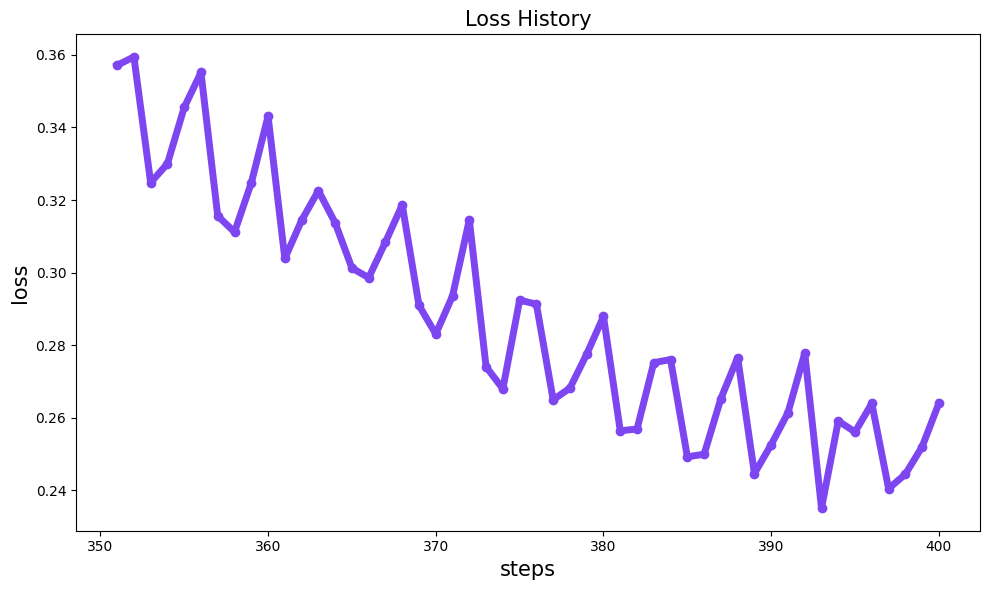

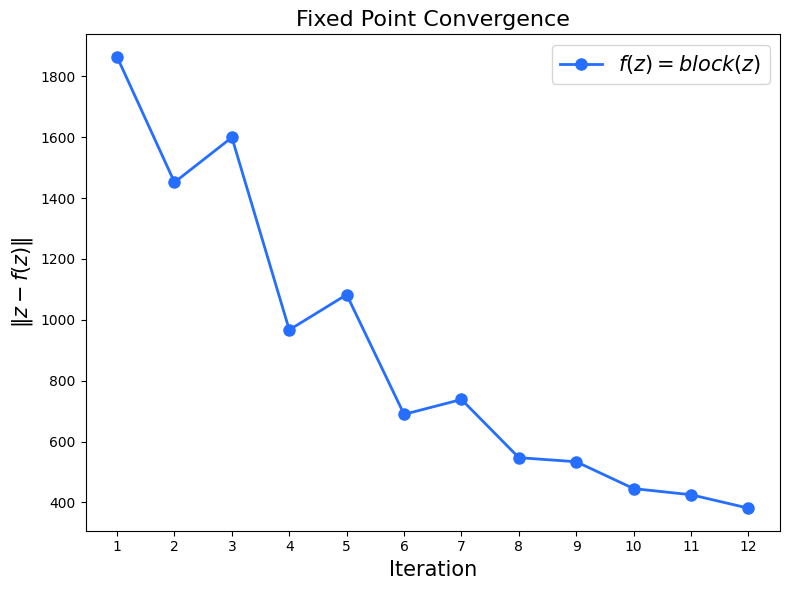

In [207]:
device_type="cuda" if torch.cuda.is_available() else "cpu"
with autocast(device_type=device_type, dtype=torch.float32):
    for epoch in range(epochs):
        for input,target in data_loader:
            input = emb(input)
            block.v_first=torch.zeros_like(input)
            outputs, info = deq(f, input)
            output = outputs[-1]
            output = head(output)
            
            loss=criterion(output.view(-1, output.size(-1)), target.view(-1))
            
            if torch.isnan(loss).any():
                print(block.state_dict())
                raise Exception("损失中出现NaN，终止训练")

            loss.backward() 
            
            optimizer.step()
            optimizer.zero_grad()
            
            loss_history.append(loss.item())
            
            lr = optimizer.param_groups[0]['lr']
            block.lr=nn.Parameter(torch.tensor(lr))
            
            clear_output(wait=True)

            print(f""" 轮数： [{epoch+1}/{epochs}] """)
            print(f""" 损失： {loss.item():.4f} """)
            print(f""" 学习率： {lr} """)
            plot_loss(loss_history, max_display=50)
            plot_eq_curve(info)
        
        scheduler.step(loss)
        if loss.item()<0.1:
            break

# 可视化训练全过程

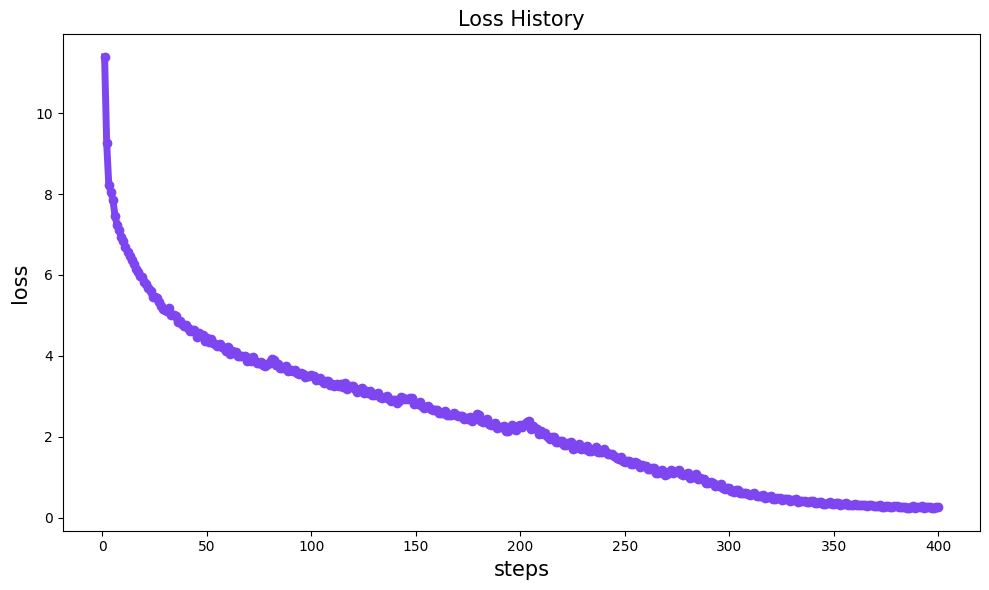

In [208]:
plot_loss(loss_history)

# 保存模型参数

In [209]:
torch.save(block.state_dict(), "block.pth")
print("模型参数已保存")
print(block.state_dict())

模型参数已保存
OrderedDict([('lr', tensor(0.0006)), ('ln1.weight', tensor([0.9956, 1.0009, 1.0005, 1.0045, 0.9897, 1.0066, 1.0035, 1.0022, 0.9967,
        1.0034, 0.9794, 0.9923, 1.0041, 0.9957, 1.0106, 0.9969, 1.0020, 0.9917,
        0.9933, 1.0031, 0.9994, 0.9938, 0.9915, 0.9964, 0.9907, 0.9992, 0.9937,
        0.9948, 0.9986, 1.0112, 0.9991, 1.0014, 1.0322, 0.9957, 1.0035, 1.0134,
        0.9842, 1.0055, 1.0056, 0.9913, 0.9982, 0.9998, 1.0064, 0.9868, 0.9886,
        1.0014, 1.0171, 0.9979, 1.0043, 0.9936, 0.9869, 0.9947, 0.9978, 0.9929,
        1.0002, 1.0158, 1.0077, 0.9971, 1.0002, 1.0023, 1.0116, 0.9962, 1.0061,
        1.0032, 1.0104, 1.0040, 0.9890, 0.9958, 1.0190, 1.0164, 1.0107, 0.9827,
        1.0143, 1.0113, 1.0066, 0.9913, 1.0005, 1.0064, 0.9965, 0.9954, 0.9984,
        0.9998, 0.9920, 1.0021, 1.0000, 0.9992, 1.0005, 1.0078, 1.0106, 0.9943,
        0.9991, 1.0005, 1.0024, 1.0011, 0.9965, 0.9948, 0.9941, 1.0008, 0.9887,
        0.9952, 1.0088, 0.9834, 1.0043, 0.9948, 0.9894, 1.01